In [1]:
import os

import geopandas
import intake
import ipywidgets
import matplotlib.pyplot as plt
import pandas
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline

import pcts_census_utils

cat = intake.open_catalog("../catalogs/*.yml")

In [2]:
parcel_to_tract = cat.crosswalk_parcels_tracts.read()

In [3]:
# ACS data for income, race, commute, tenure
census = cat.census_analysis_table.read()

In [4]:
# Census tracts
tracts = cat.census_tracts.read()
tracts = tracts.assign(
    density=tracts.HD01_VD01.astype(int)/(tracts.Shape_STAr/5280./5280.),
    population=tracts.HD01_VD01,
)

In [5]:
pcts = pcts_census_utils.subset_pcts(get_dummies=True, verbose=True)
pcts = pcts_census_utils.drop_child_cases(pcts, keep_child_entitlements=True)

Parsing PCTS case numbers
Getting dummy indicators for case types
Prefixes with no associated cases:  {'TT', 'HPO', 'VTT', 'PS'}
Suffixes appearing in the prefix position:  ['CUB', 'CUZ', 'EIR', 'ZAI']


In [6]:
# Associate each PCTS entitlement case with a census tract:
pcts = pcts.merge(
    parcel_to_tract[["GEOID", "AIN", "TOC_Tier"]],
    how="left",
    on="AIN",
)

In [7]:
# Drop some cases which are region-wide, touching thousands of parcels,
# or should otherwise be ignored.
ignore = ["CPU", "CA", "SP", "SN", "ICO", "HPOZ", "HD"]
pcts = pcts.drop(columns=ignore)

In [8]:
big_cases = pcts.CASE_ID.value_counts()
big_cases = big_cases[big_cases > 10]
pcts = pcts[~pcts.CASE_ID.isin(big_cases.index)]

In [9]:
suffixes = list(set(pcts_census_utils.FULL_SUFFIX_LIST) - set(ignore))

In [10]:
entitlement_counts = (pcts
    [["GEOID", "CASE_YR_NBR"] + suffixes]
    .astype({c: "Int64" for c in suffixes})
    .groupby(["GEOID", "CASE_YR_NBR"])
    .sum()
)
entitlement_counts

CPIOE  NC  M8  1A  CUX  ADD1  REC4  AC  CWC  SLD  \
GEOID       CASE_YR_NBR                                                     
06037101110 2012.0           0   2   0   0    0     0     0   0    0    0   
            2013.0           0   0   0   0    0     0     0   0    0    0   
            2014.0           0   0   0   0    0     0     0   0    0    0   
            2017.0           0   0   0   0    0     0     0   0    0    0   
06037101122 2013.0           0   0   0   0    0     0     0   0    0    0   
...                        ...  ..  ..  ..  ...   ...   ...  ..  ...  ...   
06037980028 2015.0           0   0   0   0    0     0     0   0    0    0   
            2016.0           0   0   0   0    0     0     0   0    0    0   
            2018.0           0   0   0   0    1     0     0   0    0    0   
            2019.0           0   0   0   0    0     0     0   0    0    0   
            2020.0           0   0   0   0    0     0     0   0    0    0   

                         ...  VZC  CPIOC  EXT  MPC  MPA  PPSP  REC1  PSH  RFA  \
GEOID       CASE_YR_NBR  ...                                                    
06037101110 2012.0       ...    0      0    0    0    0     0     0    0    0   
            2013.0       ...    0      0    0    0    0     0     0    0    0   
            2014.0       ...    0      0    1    0    0     0     0    0    0   
            2017.0       ...    0      0    0    0    0     0     0    0    0   
06037101122 2013.0       ...    0      0    0    0    0     0     0    0    0   
...                      ...  ...    ...  ...  ...  ...   ...   ...  ...  ...   
06037980028 2015.0       ...    0      0    0    0    0     0     0    0    0   
            2016.0       ...    0      0    0    0    0     0     0    0    0   
            2018.0       ...    0      0    0    0    0     0     0    0    0   
            2019.0       ...    0      0    0    0    0     0     0    0    0   
            2020.0       ...    0      0    0    0    0     0     0    0    0   

                         CPIO  
GEOID       CASE_YR_NBR        
06037101110 2012.0          0  
            2013.0          0  
            2014.0          0  
            2017.0          0  
06037101122 2013.0          0  
...                       ...  
06037980028 2015.0          0  
            2016.0          0  
            2018.0          0  
            2019.0          0  
            2020.0          0  

[6002 rows x 154 columns]

In [11]:
# Our first pass at analyzing entitlements is to count the number
# of cases for each census tract, to see which kinds of entitlements
# are being applied for in which types of census tract:
entitlement_counts = (pcts
    [["GEOID", "CASE_YR_NBR"] + suffixes]
    .astype({c: "int64" for c in suffixes})
    .groupby(["GEOID", "CASE_YR_NBR"])
    .sum()
).reset_index(level=1).rename(columns={"CASE_YR_NBR": "year"})
entitlement_counts = entitlement_counts.assign(
    year=entitlement_counts.year.astype("int64")
)

In [12]:
start_year = 2010
end_year = 2019

year_condition = entitlement_counts.year > start_year

entitlement_subset = entitlement_counts[year_condition]
include_entitlements = (
    entitlement_subset[suffixes]
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .index
)
include_entitlements

Index(['CE', 'CWC', 'CUB', 'SPP', 'TOC', 'CEX', 'MND', 'OVR', 'ZV', 'CU',
       'SPR', 'CWNC', 'ZAA', 'VSO', 'EAF', 'DRB', 'MSP', 'CDP', 'DB', 'MEL',
       'PMLA', 'ADU', 'MA', 'CUW', 'CPIOC', 'ZAD', 'UDU', 'CDO', 'ZC', 'PMEX'],
      dtype='object')

In [13]:
entitlements = (
    entitlement_subset
    [list(include_entitlements)]
    .groupby(entitlement_subset.index)
    .sum()
)
entitlements

,CE,CWC,CUB,SPP,TOC,CEX,MND,OVR,ZV,CU,...,PMLA,ADU,MA,CUW,CPIOC,ZAD,UDU,CDO,ZC,PMEX
GEOID,,,,,,,,,,,,,,,,,,,,,
06037101110,2,0,0,1,0,0,1,0,2,0,...,2,0,0,3,0,0,0,0,0,0
06037101122,3,0,0,3,0,0,0,3,0,0,...,1,1,0,0,0,0,0,0,0,0
06037101210,14,0,5,16,0,0,3,9,1,2,...,0,0,0,0,0,0,0,0,1,0
06037101220,5,0,0,2,0,0,1,5,0,0,...,0,0,0,0,0,0,1,0,0,1
06037101300,10,0,2,4,0,0,1,6,0,2,...,1,2,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06037980014,3,0,4,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06037980015,1,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
06037980019,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Merge census data with entitlements counts.
# We also bring in census geometries and the number of parcels
# in a given tract.
joined = pandas.merge(
    census.dropna().set_index("GEOID"),
    entitlements,
    how="left",
    left_index=True,
    right_index=True,
).fillna(0).reset_index().merge(
    tracts[["GEOID10", "geometry"]],
    how="left",
    left_on="GEOID",
    right_on="GEOID10",
).drop(columns="GEOID10").set_index("GEOID").dropna().assign(
    n_parcels=parcel_to_tract.groupby("GEOID").size()
)
joined

,non_car_workers,workers_total,pct_non_car_workers,zero_veh_workers,pct_zero_veh_workers,pop_renter,pop_total,pct_pop_renter,pop_whitenonhisp,pct_whitenonhisp,...,MA,CUW,CPIOC,ZAD,UDU,CDO,ZC,PMEX,geometry,n_parcels
GEOID,,,,,,,,,,,,,,,,,,,,,
06037101110,46,1927,0.023871,0,0.000000,2199,4219,0.521214,2516,0.583217,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6471651.068 1918306.964, 64719...",1199.0
06037101122,11,1907,0.005768,8,0.004195,577,3234,0.178417,2755,0.850571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6477840.844 1917081.399, 64778...",1316.0
06037101210,171,2770,0.061733,114,0.041155,5247,5987,0.876399,2991,0.494217,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTIPOLYGON (((6475267.737 1915630.020, 64752...",838.0
06037101220,54,1513,0.035691,54,0.035691,2110,3497,0.603374,1694,0.484415,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,"MULTIPOLYGON (((6477611.571 1915577.225, 64775...",721.0
06037101300,86,2041,0.042136,10,0.004900,353,4250,0.083059,3503,0.815220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"MULTIPOLYGON (((6481507.143 1914335.333, 64815...",1519.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06037930200,18,167,0.107784,0,0.000000,94,386,0.243523,271,0.646778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6434869.547 1942437.807, 64350...",NaN
06037980015,14,289,0.048443,9,0.031142,525,525,1.000000,84,0.151079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6467779.957 1740632.011, 64685...",8.0
06037980019,0,76,0.000000,0,0.000000,25,151,0.165563,125,0.827815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6388919.695 1848109.430, 63889...",53.0


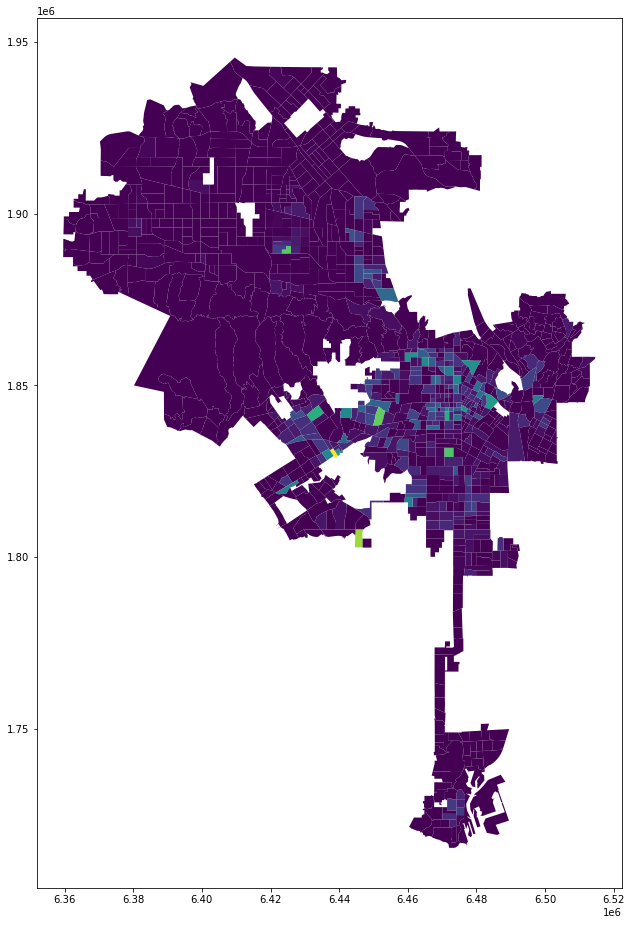

In [15]:
column = "TOC"
geopandas.GeoDataFrame(
    joined.assign(**{column: joined[column]}).dropna(), geometry="geometry"
).plot(figsize=(16,16), column=column)

In [16]:
cols=["medhhincome", "pct_pop_renter", "pct_zero_veh_workers", "density"]

In [17]:
model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.linear_model.PoissonRegressor(fit_intercept=True, tol=1.e-6))
])

In [18]:
from sklearn.utils import resample
import numpy as np
np.random.seed(1)

def fit_model(variables, target, norm=1): 
    def get_coefs(model):
        return model["regressor"].coef_

        
    samples = np.array([
        get_coefs(model.fit(*resample(
            variables,
            (target/norm).replace([np.nan, np.inf], 0.0),
        )))
        for i in range(100)
    ])
    return samples

Fitting model for CE
Fitting model for CWC
Fitting model for CUB
Fitting model for SPP
Fitting model for TOC
Fitting model for CEX
Fitting model for MND
Fitting model for OVR
Fitting model for ZV
Fitting model for CU
Fitting model for SPR
Fitting model for CWNC
Fitting model for ZAA
Fitting model for VSO
Fitting model for EAF
Fitting model for DRB
Fitting model for MSP
Fitting model for CDP
Fitting model for DB
Fitting model for MEL
Fitting model for PMLA
Fitting model for ADU
Fitting model for MA
Fitting model for CUW
Fitting model for CPIOC
Fitting model for ZAD
Fitting model for UDU
Fitting model for CDO
Fitting model for ZC
Fitting model for PMEX


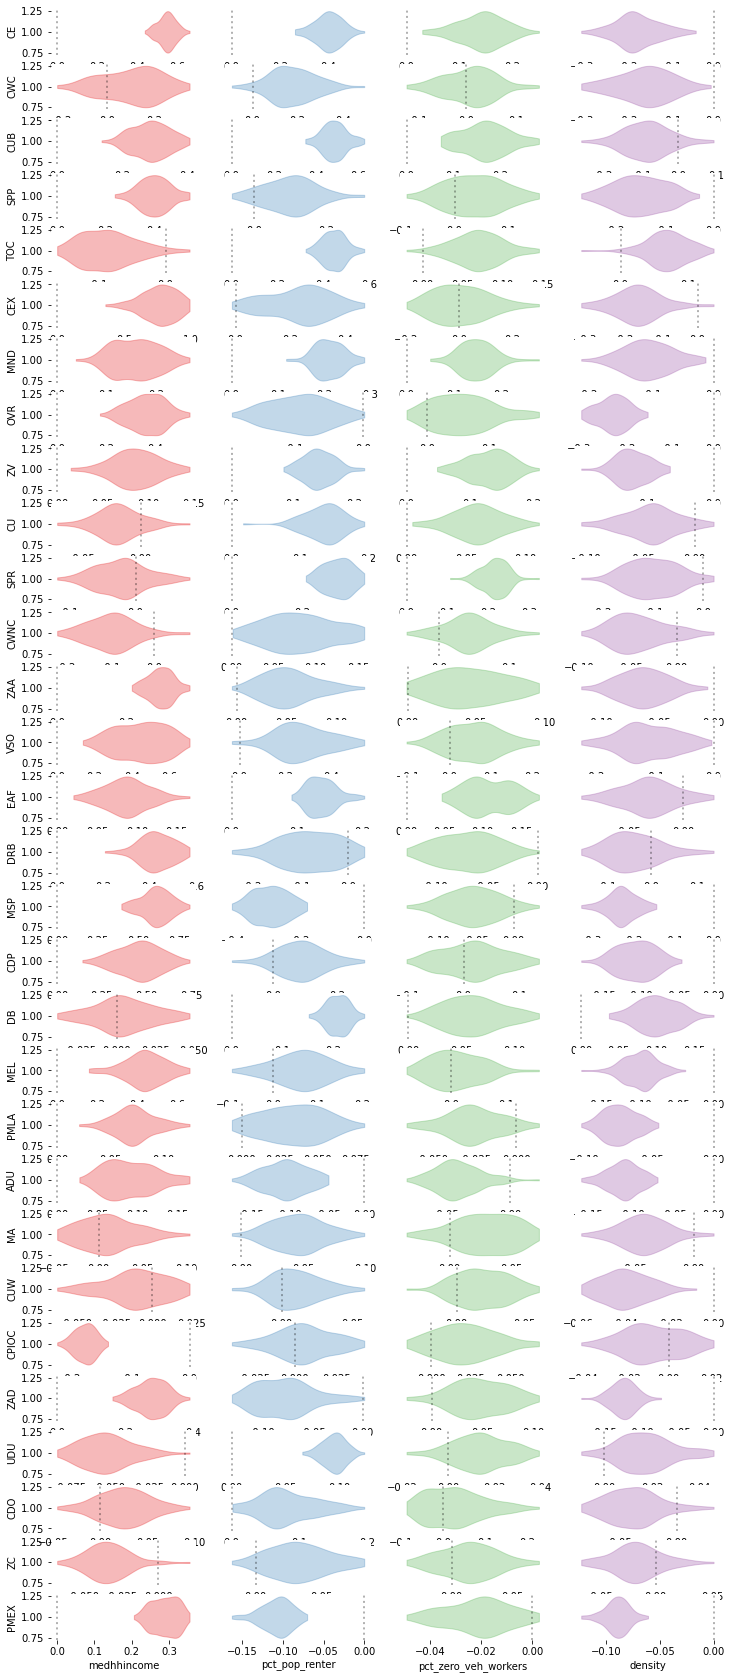

In [19]:
inc = include_entitlements

fig, axes = plt.subplots(
    len(inc),
    len(cols),
    #sharex=True,
    sharey=True,
    figsize=(12, 1*len(inc)),
)

colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]

for i, ent in enumerate(inc):
    print(f"Fitting model for {ent}")
    samples = fit_model(joined[cols], joined[ent], norm=1)
    for j, var in enumerate(cols):
        ax = axes[i, j]
        ax.axvline(0, linewidth=2, alpha=0.3, color="k", linestyle="dotted")
        for spine in ax.spines:
            ax.spines[spine].set_visible(False)
        if j == 0:
            ax.set_ylabel(ent)
        else:
            ax.tick_params(which="both", right=False, left=False)
            
        if i == len(inc)-1:
            ax.set_xlabel(var)
        else:
            ax.tick_params(which="both", bottom=False)

        parts = ax.violinplot(samples[:, j], vert=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_color(colors[j])

fig.show()

In [20]:
fig.savefig("entitlements.png")

In [21]:
def plot_model(variables, target, norm=1):
    t = (target/norm).replace([np.nan, np.inf], 0.0)
    model.fit(variables, t)
    fig, axes = plt.subplots(1, len(variables.columns), figsize=(12, 3))
    for i, var in enumerate(variables.columns):
        ax = axes[i]
        ax.scatter(variables[var], target)
        #ax.scatter(variables[var], model.predict(variables))
        ax.set_xlabel(var)
        if i == 0:
            ax.set_ylabel("Count")
    plt.close(fig) # prevent double plotting
    return fig

In [22]:
def plot_map(variables, target, norm=1):
    t = (target/norm).replace([np.nan, np.inf], 0.0)
    model.fit(variables, t)
    gdf = geopandas.GeoDataFrame(
        joined.assign(
            predict=model.predict(variables),
            target=t,
        )
    )
    vmax = gdf.target.max()
    vmin = gdf.target.min()
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    gdf.plot(column="target", cmap="viridis", ax=ax[0])
    gdf.plot(column="predict", cmap="viridis", ax=ax[1])
    ax[0].axis("off")
    ax[1].axis("off")
    ax[0].set_title(f"Number of {target.name}")
    ax[1].set_title(f"Predicted number of {target.name}")
    plt.close(fig)
    return fig

In [23]:
output = ipywidgets.Output()
dropdown = ipywidgets.Dropdown(options=inc)
norm = 1 # joined.pop_total
def on_selection(*args):
    with output:
        output.clear_output(wait=True)
        display(
            plot_map(joined[cols], joined[dropdown.value], norm),
            plot_model(joined[cols], joined[dropdown.value], norm)
        )
dropdown.observe(on_selection, names=["value"])

on_selection()
display(dropdown, output)

Dropdown(options=('CE', 'CWC', 'CUB', 'SPP', 'TOC', 'CEX', 'MND', 'OVR', 'ZV', 'CU', 'SPR', 'CWNC', 'ZAA', 'VS…

Output()